In [1]:
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import OneHotEncoder

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.solvers.mip_solver import mip_solve

c:\Users\dmitrii\miniconda3\envs\graph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dataset = read_fatahi_dataset("../data/fatahi.xlsx")

100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


In [7]:
problem_number = 0
problem = dataset[problem_number]

In [8]:
n_tasks = problem["n_operations"]
n_operations = problem["n_suboperations"]
n_cities = problem["n_cities"]
n_services = problem["n_services"]
operations = problem["operations"]
dist = problem["dist"]
time_cost = problem["time_cost"]
op_cost = problem["op_cost"]
productivity = problem["productivity"]
transportation_cost = problem["transportation_cost"]

In [4]:
problem["n_operations"], problem["n_suboperations"], problem["n_cities"], problem["n_services"]

(5, 10, 10, 10)

In [5]:
city_names = [f"city {i}" for i in range(n_cities)]
op_names = [f"operation {i+1}" for i in range(n_operations)]
tasks = [f"task {i+1}" for i in range(n_tasks)]
print("operation:")
display(pd.DataFrame(operations.astype(int), index=op_names, columns=tasks))
print("distance:")
display(pd.DataFrame(dist.round(2), index=city_names, columns=city_names))
print("time cost:")
display(pd.DataFrame(time_cost.round(2), index=op_names, columns=city_names))
print("operation cost:")
display(pd.DataFrame(op_cost.round(2), index=op_names, columns=city_names))
print("productivity:")
display(pd.DataFrame(productivity.round(2), columns=city_names))
# print("transportation cost: ", transportation_cost)

operation:


,task 1,task 2,task 3,task 4,task 5
operation 1,0,1,1,0,1
operation 2,0,0,1,1,1
operation 3,1,0,0,1,0
operation 4,0,1,0,1,0
operation 5,1,0,1,1,1
operation 6,1,1,0,0,1
operation 7,1,1,0,1,1
operation 8,1,0,1,1,1
operation 9,0,0,1,0,0
operation 10,0,0,1,1,0


distance:


,city 0,city 1,city 2,city 3,city 4,city 5,city 6,city 7,city 8,city 9
city 0,0.00,1633.84,611.70,89.72,1130.57,1238.97,1035.90,239.27,914.64,2259.97
city 1,1633.84,0.00,1739.44,1718.00,2678.56,1943.99,2397.01,1770.32,2532.43,1388.23
city 2,611.70,1739.44,0.00,649.74,1528.56,632.84,657.61,427.73,980.24,1942.79
city 3,89.72,1718.00,649.74,0.00,1041.87,1282.00,1015.66,239.62,841.99,2346.00
city 4,1130.57,2678.56,1528.56,1041.87,0.00,2103.94,1435.13,1146.31,768.87,3382.27
city 5,1238.97,1943.99,632.84,1282.00,2103.94,0.00,842.62,1059.00,1442.29,1666.51
city 6,1035.90,2397.01,657.61,1015.66,1435.13,842.62,0.00,797.75,681.46,2464.06
city 7,239.27,1770.32,427.73,239.62,1146.31,1059.00,797.75,0.00,765.06,2246.68
city 8,914.64,2532.43,980.24,841.99,768.87,1442.29,681.46,765.06,0.00,2922.97
city 9,2259.97,1388.23,1942.79,2346.00,3382.27,1666.51,2464.06,2246.68,2922.97,0.00


time cost:


,city 0,city 1,city 2,city 3,city 4,city 5,city 6,city 7,city 8,city 9
operation 1,99.00,3.79,6.28,6.53,5.19,4.38,6.76,99.00,4.76,3.38
operation 2,99.00,99.00,3.18,3.16,4.91,6.40,4.28,4.27,99.00,3.27
operation 3,3.63,99.00,99.00,4.38,6.83,6.28,5.53,99.00,5.93,5.65
operation 4,99.00,5.43,99.00,3.23,6.98,3.81,6.50,4.22,5.75,6.90
operation 5,6.16,99.00,6.39,3.49,3.93,3.59,99.00,99.00,99.00,99.00
operation 6,3.49,3.71,6.79,99.00,5.45,5.49,99.00,4.75,4.43,3.65
operation 7,4.39,5.11,6.72,6.47,5.23,99.00,5.74,3.98,6.79,5.84
operation 8,5.73,99.00,4.96,4.59,6.23,4.70,3.69,4.26,6.77,5.35
operation 9,99.00,6.96,6.28,99.00,6.55,5.93,3.75,6.08,4.90,3.06
operation 10,99.00,99.00,3.86,3.17,6.77,4.12,4.29,5.37,5.84,4.69


operation cost:


,city 0,city 1,city 2,city 3,city 4,city 5,city 6,city 7,city 8,city 9
operation 1,999.00,31.03,65.90,69.42,50.71,39.32,72.59,999.00,44.62,25.31
operation 2,999.00,999.00,22.50,22.23,46.71,67.58,37.86,37.80,999.00,23.78
operation 3,28.89,999.00,999.00,39.38,73.59,65.86,55.42,999.00,60.97,57.16
operation 4,999.00,53.98,999.00,23.23,75.66,31.38,68.94,37.05,58.48,74.54
operation 5,64.27,999.00,67.51,26.80,33.08,28.33,999.00,999.00,999.00,999.00
operation 6,26.83,29.93,73.04,999.00,54.28,54.89,999.00,44.50,40.01,29.09
operation 7,39.49,49.52,72.02,68.64,51.19,999.00,58.31,33.76,73.00,59.82
operation 8,58.28,999.00,47.46,42.20,65.24,43.83,29.70,37.58,72.76,52.86
operation 9,999.00,75.45,65.88,999.00,69.66,60.97,30.45,63.12,46.63,20.83
operation 10,999.00,999.00,31.98,22.41,72.83,35.67,38.03,53.13,59.75,43.60


productivity:


,city 0,city 1,city 2,city 3,city 4,city 5,city 6,city 7,city 8,city 9
0,0.94,0.97,0.74,0.97,0.89,0.73,0.78,0.86,0.99,0.99


In [6]:
operation_index = []
for i in range(n_tasks):
    for j in range(n_operations):
        if operations[j, i] == 1:
            operation_index.append((i, j))
operation_index.append([n_tasks // 2, -1])
operation_index.append([n_tasks // 2, n_operations])
operation_index = np.array(operation_index)
operation_index

array([[ 0,  2],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 1,  0],
       [ 1,  3],
       [ 1,  5],
       [ 1,  6],
       [ 2,  0],
       [ 2,  1],
       [ 2,  4],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 3,  1],
       [ 3,  2],
       [ 3,  3],
       [ 3,  4],
       [ 3,  6],
       [ 3,  7],
       [ 3,  9],
       [ 4,  0],
       [ 4,  1],
       [ 4,  4],
       [ 4,  5],
       [ 4,  6],
       [ 4,  7],
       [ 2, -1],
       [ 2, 10]])

In [7]:
full_op_names = [f"{i}_{j}" for (i, j) in operation_index[:-2]]
full_op_names.append("S")
full_op_names.append("F")

In [8]:
adj_operation = np.zeros((operation_index.shape[0], operation_index.shape[0]))
for i in range(operations.shape[1]):
    col_i = operations[:, i]
    path = np.where(col_i > 0)[0]
    for j in range(len(path) - 1):
        u = operation_index.tolist().index([i, path[j]])
        v = operation_index.tolist().index([i, path[j + 1]])
        adj_operation[u, v] = 1
    adj_operation[-2, operation_index.tolist().index([i, path[0]])] = 1
    adj_operation[operation_index.tolist().index([i, path[-1]]), -1] = 1
display(
    pd.DataFrame(adj_operation, index=full_op_names, columns=full_op_names).astype(int)
)

,0_2,0_4,0_5,0_6,0_7,1_0,1_3,1_5,1_6,2_0,...,3_7,3_9,4_0,4_1,4_4,4_5,4_6,4_7,S,F
0_2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1_0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1_3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1_5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1_6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
full_time_cost = np.tile(time_cost, (operations.shape[1], 1))
full_time_cost = full_time_cost[operations.T.reshape(-1).astype(bool)]
display(pd.DataFrame(full_time_cost, index=full_op_names[:-2], columns=city_names))

,city 0,city 1,city 2,city 3,city 4,city 5,city 6,city 7,city 8,city 9
0_2,3.634934,99.000000,99.000000,4.384615,6.827584,6.275490,5.529785,99.000000,5.926320,5.653988
0_4,6.161796,99.000000,6.393676,3.485659,3.934363,3.594988,99.000000,99.000000,99.000000,99.000000
0_5,3.487702,3.709432,6.788701,99.000000,5.448822,5.491820,99.000000,4.749919,4.429195,3.649531
0_6,4.392491,5.108806,6.715662,6.474143,5.227931,99.000000,5.736078,3.982976,6.786001,5.844118
0_7,5.734408,99.000000,4.961135,4.585497,6.231565,4.701929,3.693122,4.255419,6.768645,5.346953
1_0,99.000000,3.788065,6.278703,6.530230,5.193722,4.380125,6.756335,99.000000,4.758298,3.379271
1_3,99.000000,5.426878,99.000000,3.230857,6.976000,3.813059,6.495384,4.217625,5.748618,6.895836
1_5,3.487702,3.709432,6.788701,99.000000,5.448822,5.491820,99.000000,4.749919,4.429195,3.649531
1_6,4.392491,5.108806,6.715662,6.474143,5.227931,99.000000,5.736078,3.982976,6.786001,5.844118
2_0,99.000000,3.788065,6.278703,6.530230,5.193722,4.380125,6.756335,99.000000,4.758298,3.379271


In [10]:
full_op_cost = np.tile(op_cost, (operations.shape[1], 1))
full_op_cost = full_op_cost[operations.T.reshape(-1).astype(bool)]
display(pd.DataFrame(full_op_cost, index=full_op_names[:-2], columns=city_names))

,city 0,city 1,city 2,city 3,city 4,city 5,city 6,city 7,city 8,city 9
0_2,28.889077,999.000000,999.000000,39.384609,73.586175,65.856860,55.416994,999.000000,60.968486,57.155829
0_4,64.265147,999.000000,67.511461,26.799225,33.081082,28.329838,999.000000,999.000000,999.000000,999.000000
0_5,26.827828,29.932044,73.041809,999.000000,54.283508,54.885484,999.000000,44.498864,40.008731,29.093435
0_6,39.494875,49.523290,72.019273,68.638004,51.191034,999.000000,58.305087,33.761668,73.004016,59.817656
0_7,58.281706,999.000000,47.455891,42.196964,65.241911,43.827001,29.703711,37.575870,72.761037,52.857345
1_0,999.000000,31.032916,65.901849,69.423226,50.712105,39.321755,72.588694,999.000000,44.616165,25.309800
1_3,999.000000,53.976295,999.000000,23.231997,75.663993,31.382821,68.935371,37.046748,58.480653,74.541706
1_5,26.827828,29.932044,73.041809,999.000000,54.283508,54.885484,999.000000,44.498864,40.008731,29.093435
1_6,39.494875,49.523290,72.019273,68.638004,51.191034,999.000000,58.305087,33.761668,73.004016,59.817656
2_0,999.000000,31.032916,65.901849,69.423226,50.712105,39.321755,72.588694,999.000000,44.616165,25.309800


In [11]:
city_to_op = [
    (city_names[i], full_op_names[j])
    for i, j in zip(*np.where(full_op_cost < 999)[::-1])
]
op_to_op = [
    (full_op_names[i], full_op_names[j]) for i, j in zip(*np.where(adj_operation > 0))
]
city_to_city = [(city_names[i], city_names[j]) for i, j in zip(*np.where(dist > 0))]

In [12]:
G = nx.DiGraph()
G.add_nodes_from(full_op_names)
G.add_nodes_from(city_names)
G.add_edges_from(city_to_op)
G.add_edges_from(op_to_op)
G.add_edges_from(city_to_city)
pos = dict()
for i, oname in enumerate(full_op_names):
    pos[oname] = list(operation_index[i][::-1])
for key, val in nx.circular_layout(
    G.subgraph(city_names), scale=2, center=((n_operations - 1) / 2, 8)
).items():
    pos[key] = val

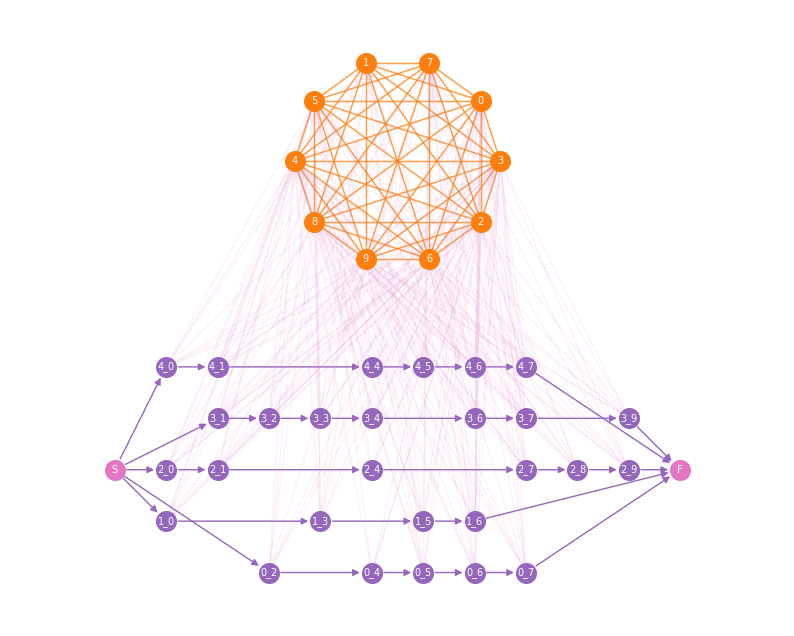

In [13]:
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=full_op_names[:-2],
    node_size=200,
    node_color="tab:purple",
)
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=["S", "F"],
    node_size=200,
    node_color="tab:pink",
)
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=city_names,
    node_size=200,
    node_color="tab:orange",
)
nx.draw_networkx_labels(
    G,
    pos,
    labels={node: node for node in full_op_names},
    font_color="white",
    font_size=7,
)
nx.draw_networkx_labels(
    G,
    pos,
    labels={node: node[5:] for node in city_names},
    font_color="white",
    font_size=7,
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=op_to_op,
    edge_color="tab:purple",
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=city_to_city,
    edge_color="tab:orange",
    arrows=False,
    alpha=0.5,
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=city_to_op,
    edge_color="tab:pink",
    arrows=False,
    alpha=0.1,
)
plt.axis("equal")
plt.axis("off")
plt.show()

In [14]:
# delta, gamma, status, value = mip_solve(problem)
# status, value
# np.save('gamma_0.npy', gamma)
# np.save('delta_0.npy', delta)

In [15]:
gamma = np.load(f'solutions/gamma_{problem_number}.npy')
delta = np.load(f'solutions/delta_{problem_number}.npy')

In [16]:
city_to_op_solution = []
for o, t, c in zip(*np.where(gamma == 1)):
    city_to_op_solution.append((f"city {c}", f"{t}_{o}"))

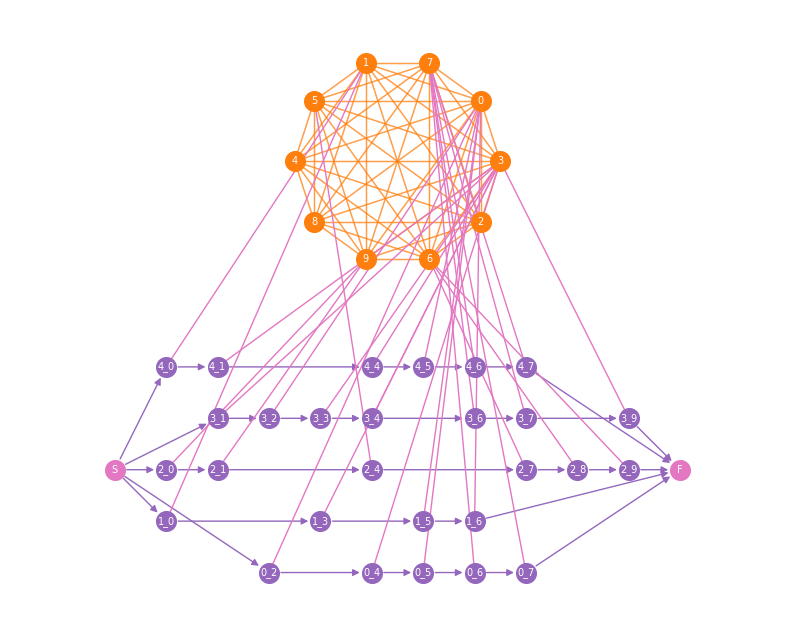

In [17]:
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=full_op_names[:-2],
    node_size=200,
    node_color="tab:purple",
)
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=["S", "F"],
    node_size=200,
    node_color="tab:pink",
)
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=city_names,
    node_size=200,
    node_color="tab:orange",
)
nx.draw_networkx_labels(
    G,
    pos,
    labels={node: node for node in full_op_names},
    font_color="white",
    font_size=7,
)
nx.draw_networkx_labels(
    G,
    pos,
    labels={node: node[5:] for node in city_names},
    font_color="white",
    font_size=7,
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=op_to_op,
    edge_color="tab:purple",
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=city_to_city,
    edge_color="tab:orange",
    arrows=False,
    alpha=0.5,
)
nx.draw_networkx_edges(
    G,
    pos=pos,
    edgelist=city_to_op_solution,
    edge_color="tab:pink",
    arrows=False,
)
plt.axis("equal")
plt.axis("off")
plt.show()

Обозначения:

* $N_o$ — вершины операции
* $N_s$ — вершины споинты
* $E_{so}$ — ребра типа споинт, операция
* $E_{os}$ — ребра типа операция, споинт
* $E_{ss}$ — ребра типа споинт, споинт
* $E_{oo}$ — ребра типа операция, операция
* $O_i$ — фичи операции i: индикатор номера операции
* $S_i$ — фичи споинта i: производительность
* $OS_{ij}$ — фичи на ребре so i j: время обслуживания и затраты
* $SS_{ij}$ — фичи на ребре ss i j: расстояние

In [18]:
graph_data = {
    ("s", "ss", "s"): np.where(dist > 0),
    ("o", "os", "s"): np.where(full_op_cost < 999),
    ("s", "so", "o"): np.where(full_op_cost < 999)[::-1],
    ("o", "forward", "o"): np.where(adj_operation > 0),
    ("o", "backward", "o"): np.where(adj_operation > 0)[::-1],
}
g = dgl.heterograph(graph_data)
g = dgl.add_self_loop(g, etype="ss")

In [19]:
target = []
for full_o, c in zip(*np.where(full_op_cost < 999)):
    t, o = operation_index[full_o]
    target.append(gamma[o, t, c])

In [20]:
def find_pairs(gamma):
    pairs_new = []
    indices = np.where(gamma.swapaxes(0, 1) == 1)
    for (t1, o1, c1), (t2, o2, c2) in zip(zip(*indices), 
                                        zip(*[index[1:] for index in indices])):
        if t1 == t2:
            pairs_new.append([c1, c2])
    return np.unique(np.stack(pairs_new, axis=0),axis=0)

def find_mask(pairs, dist):
    mask = (
        np.stack(np.where(dist>0)).T == np.array(pairs)[:,None]
    ).all(2).any(0)
    return mask

def create_dtarget(delta, dist, n_services):
    delta_target = np.zeros((dist.shape[0]**2, n_services))
    for i, (c1, c2) in enumerate(zip(*np.where(dist>0))):
        if len(np.nonzero(delta[:,c1,c2,:,:])[0]) > 0:
            delta_target[i, np.nonzero(delta[:,c1,c2,:,:])[0][0]] = 1
    return delta_target

In [21]:
pairs = find_pairs(gamma)
mask = find_mask(pairs, dist)
delta_target = create_dtarget(delta, dist, n_services)

### Delta demonstration

In [22]:
for op_num in range(5):
    print('task:', op_num)
    city_list = []
    for i, sub_op in enumerate(np.nonzero(operations[:,op_num])[0]):
        c = np.nonzero(gamma[sub_op,op_num,:])
        city_list.append(c)
        if i != 0:
            print(city_list[i-1][0], c[0])
            print(delta[:,city_list[i-1],c,sub_op,op_num].reshape(-1))
    print('\n')

task: 0
[0] [3]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[3] [0]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0] [7]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[7] [7]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


task: 1
[1] [3]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[3] [0]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0] [0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


task: 2
[9] [9]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9] [5]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[5] [6]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[6] [6]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[6] [6]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


task: 3
[3] [0]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0] [3]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[3] [3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3] [7]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7] [7]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7] [3]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


task: 4
[1] [3]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[3] [3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3] [0]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0] [7]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[7] [7]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]




## Features assigning

In [23]:
op_feat = (
    OneHotEncoder()
    .fit_transform(operation_index[g.nodes("o").numpy()][:, [1]])
    .toarray()
)
g.ndata["feat"] = {
    "o": torch.FloatTensor(op_feat),
    "s": torch.FloatTensor(productivity.T),
}
u_idx, v_idx = g.edges(etype="os")
serves_feat = np.array(
    [
        full_op_cost[u_idx, v_idx],
        full_time_cost[u_idx, v_idx],
    ]
)
transp = transportation_cost[:,
                             g.edges(etype="ss")[0],
                             g.edges(etype="ss")[1]] * dist[g.edges(etype="ss")]
g.edata["feat"] = {
    "os": torch.FloatTensor(serves_feat.T),
    "ss": torch.FloatTensor(transp.T),
}
# g.edata["target"] = {
#     "os": torch.FloatTensor(target_new),
# }

In [25]:
transp.T.shape

(100, 10)

In [50]:
print(operation_index[g.nodes("o").numpy()][:, [1]].shape)
print(op_feat.shape)

(30, 1)
(30, 12)


In [51]:
op_feat

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.,